# Libraries

In [ ]:
import  pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

from tensorflow.keras import layers, models, losses, metrics, callbacks, optimizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
%load_ext tensorboard

In [ ]:
seed = 42

# Data Links

+ Spine Dataset: http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip

+ Breast Cancer Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

+ Ionosphere Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/

+ Ablone Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/

+ Forest Fires: https://archive.ics.uci.edu/ml/datasets/Forest+Fires

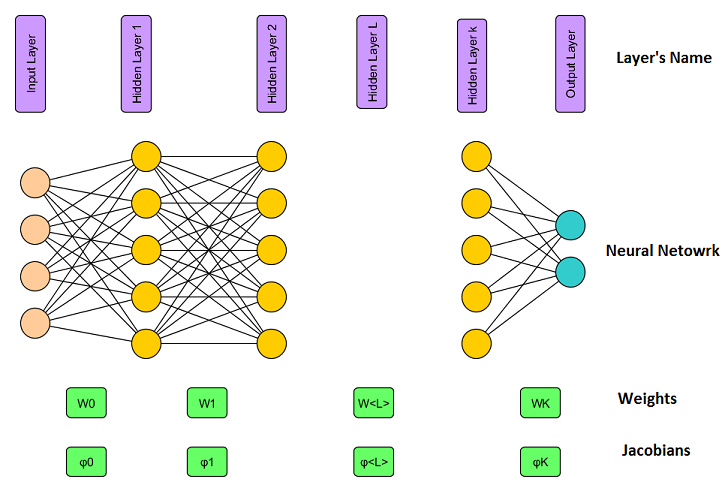

We start a regular multi layer perceptron architecure of neural netowrk with $k$ hidden layers. For the sake of notation, let's refer input layer as $h_0$.

The error of a batch is given as:
$$e = \sum_{i=1}^{m} f(y_i^{true}, y_i^{pred})$$
where $m$ is batch size.

The local jacobians are given as:
$${\partial e \over \partial h_k} = \varphi_k$$
$${\partial h_{l-1} \over \partial h_l} = \varphi_{l-1}, \text{for } l \in {1, ..., k-1}$$
For each data point the shape of jacobian, $\varphi_l$ is same as the weight matrix between hidden layers $h_l$ and $h_{l+1}$.

The global jacobian at any point (as done by backpropagation) can be calcaulted as:
$${\partial e \over \partial h_{l}} = \prod_{i=l}^{k-1} {\partial h_{i+1} \over h_{i}} . {\partial e \over \partial h_{k}}$$
$${\partial e \over \partial h_{l}} =  \varphi_l. \varphi_{l+1}. ... \varphi_{k}$$

For a batch of size $m$, we receive a batch of m jacobians corrosponding to each data point. In this case, the jacobian which is used is as follow:
$$\varphi_l = \sum_{i=1}^{m}\varphi_{l}^{<i>}.$$

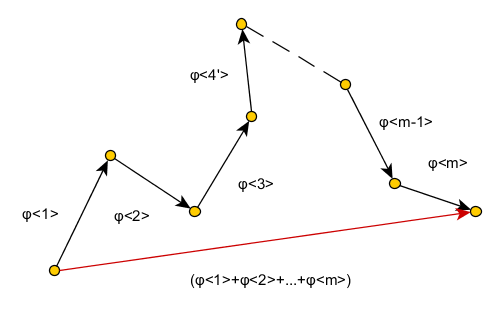

The above image shows geomtrically what we ahve mentioned in step above.
 
Any weight matrix say $W_l$ and $\varphi_l$ has same dimension and it is given as $(|h_{l}|, |h_{l+1}|)$.
 
The SVD of the $\varphi_l$ can be represented as:
$$SVD(\varphi_1) = U \Sigma V^T$$
where $U \in \mathbb{R}^{h_{l} \text{ x } h_{l+1}}$ and $\Sigma, V \in \mathbb{R}^{h_{l+1} \text{ x } h_{l+1}}$
 
When a neural netowrk is reached to convergence for a given data shard, we can perform SVD on the local jacobian $\varphi_l$ and choose the numbers of singualr values which contains the infomration just above or equal the threshold. Let threshold be $\pi$, then the number of required singular vectors can be calculated as
$$N_l' = argmin \Big\{\Big |F_{csum}\Big({diag(\Sigma) \over \sum diag(\Sigma)}\Big) - \pi \vec 1 \Big| \Big\}$$
where $F_{csum}$ represents cummulative sum.
 
After this we can say that $U[1:N_L']$ represent the maximum amount of information holds by $\varphi_l$. If $N_L' << h_{l+1}$, we can say that there is a lot of sparsity in original system, hence the no of neuron can be dropped from $h_{l+1}$ to $N_l'$.

# Utility Functions

In [ ]:
def get_dataset(X, Y):
    n = X.shape[0]
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)

    # Train:Validation:Test :: 70%:10%:20%
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=seed)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    return train_ds, val_ds, test_ds

In [ ]:
def get_model(input_shape, hidden = [100], n_class=None, task="class"):
    # Input Layers
    model = models.Sequential([layers.InputLayer(input_shape=input_shape)])
    
    # Hidden Layers
    for h in hidden:
        model.add(layers.Dense(units=h, activation="relu", kernel_initializer="he_normal"))
    
    # Output Layers
    if task == "class" and n_class == 2:
        model.add(layers.Dense(units=1, activation="sigmoid", kernel_initializer="he_normal"))
    elif task == "class":
        model.add(layers.Dense(units=n_class, activation="softmax", kernel_initializer="he_normal"))
    else:
        model.add(layers.Dense(units=1, kernel_initializer="he_normal"))

    return model

In [ ]:
bce_loss = losses.BinaryCrossentropy(name="bce")
smx_loss = losses.CategoricalCrossentropy(name="cce")
reg_loss = losses.MeanSquaredError(name="mse")

In [ ]:
def gradient(model, inputs, targets, loss):
    with tf.GradientTape() as tape:
        preds = model(inputs)
        loss_value = loss(targets, preds)
        return preds, loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
def train_v2(model, train_data, valid_data, epochs, loss, bsize=8, patience=8, task="class"):
    # Compiling Model
    if task == "class":
        model.compile(loss=loss, optimizer="adam", metrics=["accuracy", 
                                                            metrics.Precision(name="prec"), 
                                                            metrics.Recall(name="rec"),
                                                            metrics.AUC(name="auc", curve="roc")])
    else:
        model.compile(loss=loss, optimizer="adam", metrics=[metrics.MeanAbsoluteError(name="mae"), 
                                                            metrics.MeanSquaredLogarithmicError(name="msle"),
                                                            metrics.RootMeanSquaredError("rmse")])
  
    # Preparing some Callbacks
    tboard = callbacks.TensorBoard(log_dir='logs/'+str(datetime.now()), histogram_freq=0, write_graph=True)
    estop = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

    # Shuffle and Batch Training Dataset
    t_size = tf.data.experimental.cardinality(train_data).numpy()
    train_data = train_data.shuffle(t_size).batch(bsize, drop_remainder=True)

    # Shuffle and Batch Training Dataset
    v_size = tf.data.experimental.cardinality(train_data).numpy()
    valid_data = train_data.shuffle(v_size).batch(bsize, drop_remainder=True)

    # Fitting Model
    history = model.fit(train_data, 
                        epochs = epochs,
                        verbose = 2,
                        validation_data = valid_data,
                        callbacks = [estop, tboard])
    
    return history

In [ ]:
def plot_jacobian(nn_model, loss):
    # Fetch Gradients
    a, b = list(train_ds.batch(10).take(1))[0]
    res = gradient(nn_model, a, b, loss)[-1]
    res = [x.numpy() for x in res]

    fig, ax = plt.subplots(1, len(res)//2, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 3, 1]})

    jacobians = []

    for idx, i in enumerate(range(0, len(res)//2 + 2, 2)):
        # Plotting Wi Matrix
        Wi = np.vstack((res[i], res[i+1].reshape(-1, res[i+1].shape[0])))
        imgi = ax[idx].imshow(Wi, cmap="gray")
        ax[idx].set_title(f"[W{idx+1} Matrix | B{idx+1} Matrix] <=> [{res[i].shape} | {res[i+1].reshape(-1, res[i+1].shape[0]).shape}]")
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        fig.colorbar(imgi, ax=ax[idx])

        jacobians.append(Wi)

    plt.show()

    return jacobians

In [ ]:
def perform_pca(matrix):
    # ignore V
    pca_obj = PCA(W1.shape[1], random_state=seed)
    U = pca_obj.fit_transform(W1)
    sigma = pca_obj.explained_variance_

    return U, sigma, U

In [ ]:
def visualize_SVD(matrix, mode="svd"):
    U, sigma, V_star = None, None, None
    if mode == "svd":
        U, sigma, V_star = np.linalg.svd(matrix)
    else:
        U, sigma, V_star = perform_pca(matrix)

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Plotting U Matrix
    img1 = ax[0].imshow(U, cmap="gray")
    ax[0].set_title("U Matrix => {}".format(U.shape))
    fig.colorbar(img1, ax=ax[0])

    # Plotting Log(sigma) Matrix
    sigma = np.log(np.diag(sigma) + 1e-40)
    img2 = ax[1].imshow(sigma, cmap="gray")
    ax[1].set_title("log(Sigma) Matrix => {}".format(sigma.shape))
    fig.colorbar(img2, ax=ax[1])

    # Plotting V* Matrix
    img3 = ax[2].imshow(V_star, cmap="gray")
    ax[2].set_title("V_star Matrix => {}".format(V_star.shape))
    fig.colorbar(img3, ax=ax[2])

    plt.show()

In [ ]:
def get_new_param(jacobian, threshold=0.2):
    _, sigma, _ = np.linalg.svd(jacobian)
    log_sigma = np.log(sigma)
    log_sigma[np.abs(log_sigma) == np.inf] = -400
    csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))
    return np.min(np.argwhere(csum_norm_log_sigma - threshold > 0)) + 1

In [ ]:
def final_summary(nn_model):
    # Model Architecture
    nn_model.summary()

    # Train Scores
    print("Train Score:")
    nn_model.evaluate(train_ds.batch(8))

    # Validation Scores
    print("Valid Score:")
    nn_model.evaluate(val_ds.batch(8))

    # Testing Scores
    print("Test Score:")
    nn_model.evaluate(test_ds.batch(8));

# Breast Cancer Data
+ Binary Classification
+ 569 records (357, 212)

### Data Preparation

In [ ]:
data = load_breast_cancer()
X = data.data
Y = data.target

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)

### Modelling

In [ ]:
model = get_model((30,), hidden = [70, 30], n_class=2, task="class")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                2170      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,331
Trainable params: 4,331
Non-trainable params: 0
_________________________________________________________________


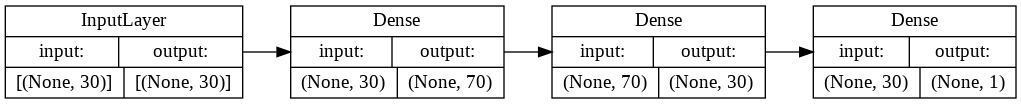

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)
history = train_v2(model, train_ds, val_ds, 100, bce_loss)

Epoch 1/100
49/49 - 5s - loss: 23.7330 - accuracy: 0.6735 - prec: 0.7668 - rec: 0.6923 - auc: 0.6768 - val_loss: 0.7326 - val_accuracy: 0.8776 - val_prec: 0.8947 - val_rec: 0.9132 - val_auc: 0.9100
Epoch 2/100
49/49 - 0s - loss: 0.8814 - accuracy: 0.8648 - prec: 0.8916 - rec: 0.8952 - auc: 0.9009 - val_loss: 0.8733 - val_accuracy: 0.9010 - val_prec: 0.8700 - val_rec: 0.9918 - val_auc: 0.9006
Epoch 3/100
49/49 - 0s - loss: 0.9759 - accuracy: 0.8520 - prec: 0.8795 - rec: 0.8866 - auc: 0.8972 - val_loss: 0.6331 - val_accuracy: 0.9010 - val_prec: 0.8830 - val_rec: 0.9710 - val_auc: 0.9198
Epoch 4/100
49/49 - 0s - loss: 0.7235 - accuracy: 0.8903 - prec: 0.9116 - rec: 0.9153 - auc: 0.9166 - val_loss: 0.4867 - val_accuracy: 0.9036 - val_prec: 0.9080 - val_rec: 0.9419 - val_auc: 0.9397
Epoch 5/100
49/49 - 0s - loss: 1.3778 - accuracy: 0.8546 - prec: 0.8871 - rec: 0.8835 - auc: 0.8663 - val_loss: 0.7637 - val_accuracy: 0.8594 - val_prec: 0.9571 - val_rec: 0.8171 - val_auc: 0.9313
Epoch 6/100
49

### Results

In [ ]:
# Train Scores
print("Train Score:")
model.evaluate(train_ds.batch(8))

# Validation Scores
print("Valid Score:")
model.evaluate(val_ds.batch(8))

# Testing Scores
print("Test Score:")
model.evaluate(test_ds.batch(8));

Train Score:
50/50 [==============================] - 1s 4ms/step - loss: 0.4536 - accuracy: 0.9070 - prec: 0.9352 - rec: 0.9167 - auc: 0.9479
Valid Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.9474 - prec: 0.9697 - rec: 0.9412 - auc: 0.9431
Test Score:
15/15 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9561 - prec: 0.9714 - rec: 0.9577 - auc: 0.9964


### Jacobian Visualization

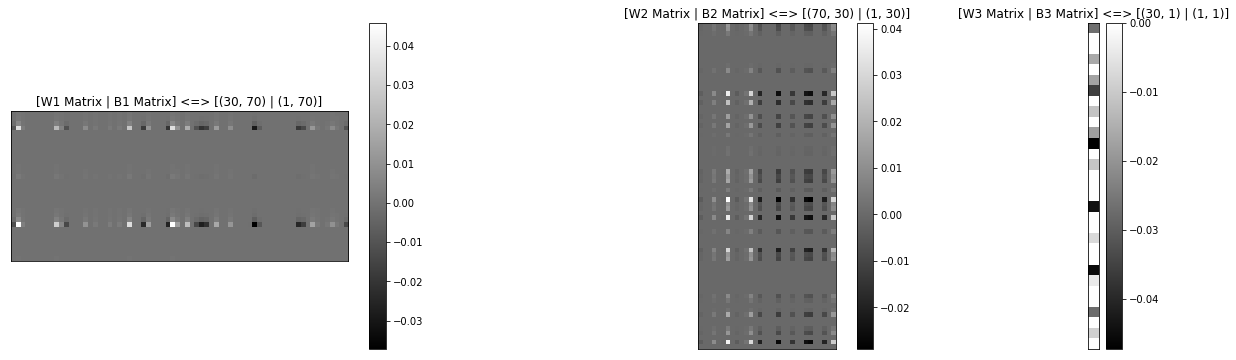

In [ ]:
[W1, W2, W3] = plot_jacobian(model, bce_loss)

### SVD of Jacobians

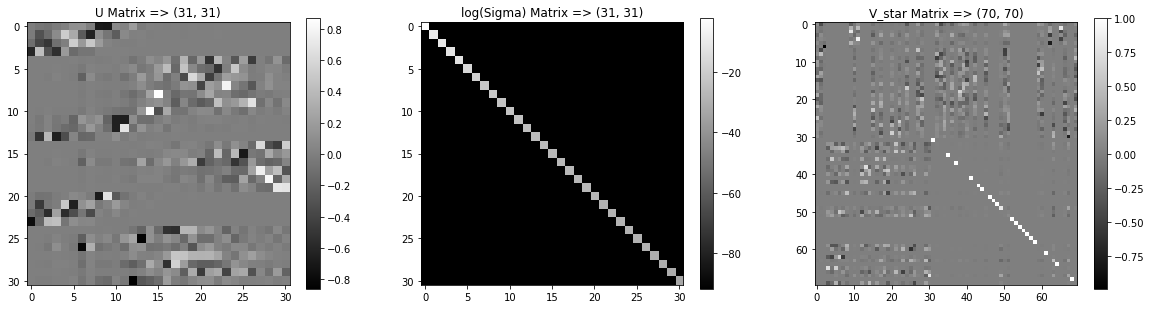

In [ ]:
visualize_SVD(W1)

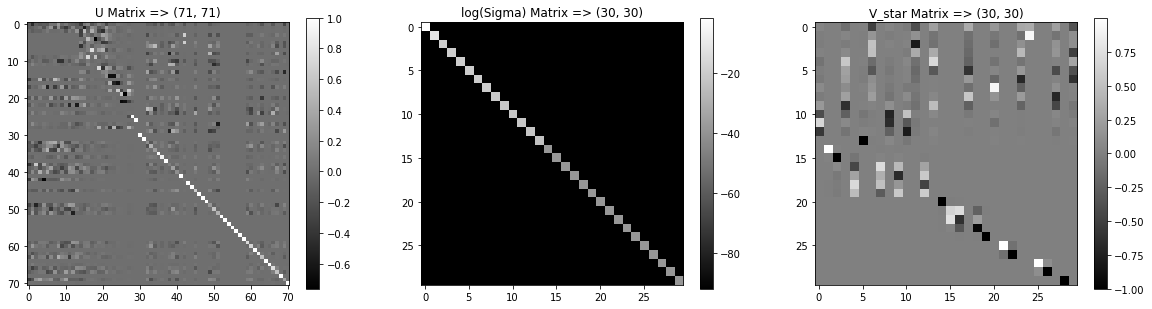

In [ ]:
visualize_SVD(W2)

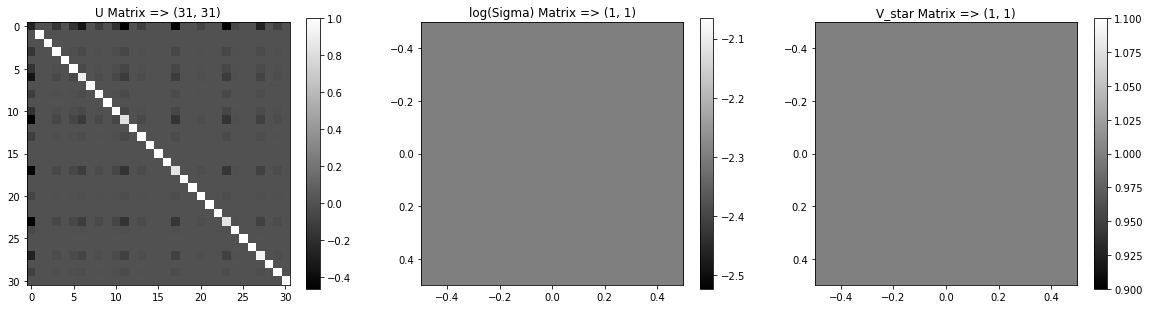

In [ ]:
visualize_SVD(W3)

### Estimating NN Params

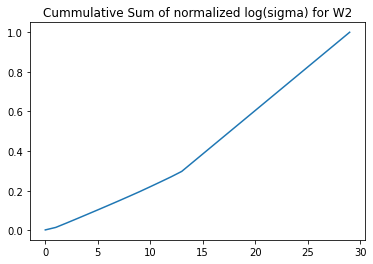

In [ ]:
_, sigma, _ = np.linalg.svd(W2)
log_sigma = np.log(sigma)
csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))

plt.plot(csum_norm_log_sigma)
plt.title("Cummulative Sum of normalized log(sigma) for W2")
plt.show()

In [ ]:
h1 = get_new_param(W1, )
h1

11

In [ ]:
h2 = get_new_param(W2)
h2

11

### Fitting New Model

In [ ]:
n_model = get_model((30,), hidden=[h1, h2], n_class=2, task="class")
n_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 11)                341       
_________________________________________________________________
dense_4 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 12        
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_v2(n_model, train_ds, val_ds, 100, bce_loss)

Epoch 1/100
49/49 - 2s - loss: 1.1248 - accuracy: 0.7372 - prec: 0.8139 - rec: 0.7581 - auc: 0.7894 - val_loss: 0.7204 - val_accuracy: 0.8411 - val_prec: 0.8131 - val_rec: 0.9711 - val_auc: 0.8578
Epoch 2/100
49/49 - 0s - loss: 0.6319 - accuracy: 0.8189 - prec: 0.8636 - rec: 0.8462 - auc: 0.8659 - val_loss: 0.5110 - val_accuracy: 0.8620 - val_prec: 0.8519 - val_rec: 0.9465 - val_auc: 0.8830
Epoch 3/100
49/49 - 0s - loss: 0.5581 - accuracy: 0.8342 - prec: 0.8710 - rec: 0.8675 - auc: 0.8777 - val_loss: 0.5234 - val_accuracy: 0.8724 - val_prec: 0.8505 - val_rec: 0.9715 - val_auc: 0.8892
Epoch 4/100
49/49 - 0s - loss: 0.5493 - accuracy: 0.8367 - prec: 0.8710 - rec: 0.8710 - auc: 0.8878 - val_loss: 0.6466 - val_accuracy: 0.7760 - val_prec: 0.9286 - val_rec: 0.6983 - val_auc: 0.9235
Epoch 5/100
49/49 - 0s - loss: 0.5101 - accuracy: 0.8469 - prec: 0.8795 - rec: 0.8795 - auc: 0.8908 - val_loss: 0.4209 - val_accuracy: 0.8880 - val_prec: 0.9139 - val_rec: 0.9102 - val_auc: 0.9131
Epoch 6/100
49/

### Summary

In [ ]:
# Old Model

final_summary(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                2170      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,331
Trainable params: 4,331
Non-trainable params: 0
_________________________________________________________________
Train Score:
50/50 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.9070 - prec: 0.9352 - rec: 0.9167 - auc: 0.9479
Valid Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.9474 - prec: 0.9697 - rec: 0.9412 - auc: 0.9431
Test Score:
15/15 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9561 -

In [ ]:
# New Model 
final_summary(n_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 11)                341       
_________________________________________________________________
dense_4 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 12        
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________
Train Score:
50/50 [==============================] - 1s 3ms/step - loss: 0.1396 - accuracy: 0.9422 - prec: 0.9421 - rec: 0.9683 - auc: 0.9856
Valid Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.1810 - accuracy: 0.9649 - prec: 0.9706 - rec: 0.9706 - auc: 0.9731
Test Score:
15/15 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.9649 - p

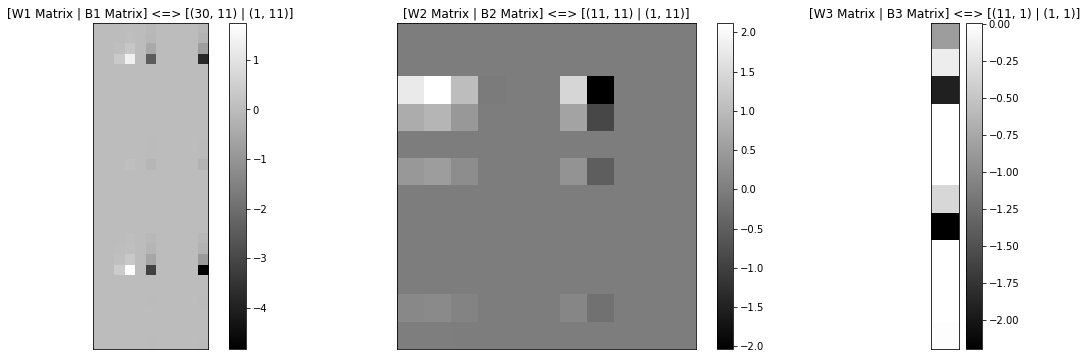

In [ ]:
[W1, W2, W3] = plot_jacobian(n_model, bce_loss)

# Ionosphere Data
+ Binary Classification
+ 351 records (225, 126)

### Data Preparation

In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data

--2021-07-01 11:28:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76467 (75K) [application/x-httpd-php]
Saving to: ‘ionosphere.data’

ionosphere.data     100%[===================>]  74.67K  --.-KB/s    in 0.06s   

2021-07-01 11:28:14 (1.15 MB/s) - ‘ionosphere.data’ saved [76467/76467]



In [ ]:
data = pd.read_csv("ionosphere.data", header=None)
X = data[np.arange(34)].values
Y = data[34].apply(lambda x: 0 if x is "b" else 1).values

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)

### Modelling

In [ ]:
model = get_model((34,), hidden = [70, 30], n_class=2, task="class")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 70)                2450      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


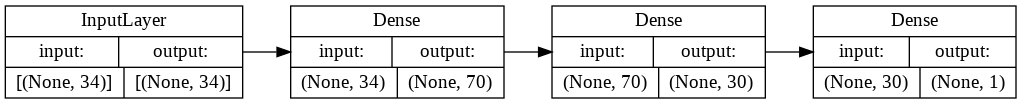

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
history = train_v2(model, train_ds, val_ds, 100, bce_loss)

Epoch 1/100
30/30 - 2s - loss: 0.5725 - accuracy: 0.7042 - prec: 0.6920 - rec: 0.9873 - auc: 0.7516 - val_loss: 0.4730 - val_accuracy: 0.7708 - val_prec: 0.7381 - val_rec: 1.0000 - val_auc: 0.8943
Epoch 2/100
30/30 - 0s - loss: 0.4106 - accuracy: 0.8333 - prec: 0.7970 - rec: 1.0000 - auc: 0.9353 - val_loss: 0.3676 - val_accuracy: 0.8750 - val_prec: 0.8378 - val_rec: 1.0000 - val_auc: 0.9634
Epoch 3/100
30/30 - 0s - loss: 0.3234 - accuracy: 0.9167 - prec: 0.8908 - rec: 0.9936 - auc: 0.9729 - val_loss: 0.2715 - val_accuracy: 0.9323 - val_prec: 0.9124 - val_rec: 0.9921 - val_auc: 0.9810
Epoch 4/100
30/30 - 0s - loss: 0.2543 - accuracy: 0.9417 - prec: 0.9222 - rec: 0.9935 - auc: 0.9811 - val_loss: 0.2137 - val_accuracy: 0.9479 - val_prec: 0.9323 - val_rec: 0.9920 - val_auc: 0.9870
Epoch 5/100
30/30 - 0s - loss: 0.2060 - accuracy: 0.9500 - prec: 0.9390 - rec: 0.9872 - auc: 0.9871 - val_loss: 0.1692 - val_accuracy: 0.9583 - val_prec: 0.9462 - val_rec: 0.9919 - val_auc: 0.9905
Epoch 6/100
30/

### Results

In [ ]:
# Train Scores
print("Train Score:")
model.evaluate(train_ds.batch(8))

# Validation Scores
print("Valid Score:")
model.evaluate(val_ds.batch(8))

# Testing Scores
print("Test Score:")
model.evaluate(test_ds.batch(8));

Train Score:
31/31 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.9959 - prec: 0.9937 - rec: 1.0000 - auc: 1.0000
Valid Score:
5/5 [==============================] - 0s 6ms/step - loss: 0.3478 - accuracy: 0.8857 - prec: 0.8800 - rec: 0.9565 - auc: 0.9710
Test Score:
9/9 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9437 - prec: 0.9149 - rec: 1.0000 - auc: 0.9975


### Jacobian Visualization

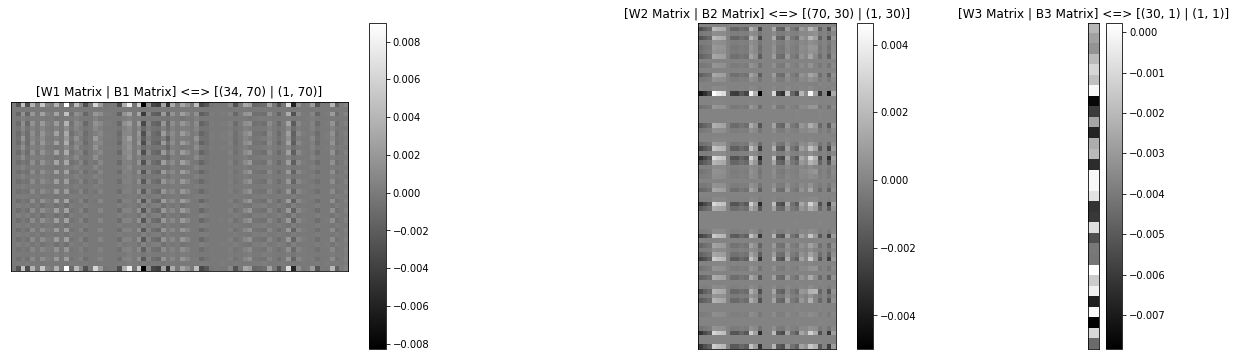

In [ ]:
[W1, W2, W3] = plot_jacobian(model, bce_loss)

### SVD of Jacobians

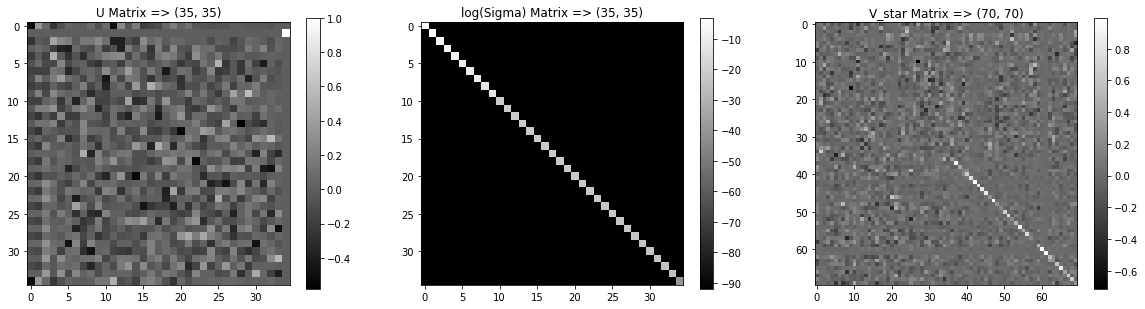

In [ ]:
visualize_SVD(W1)

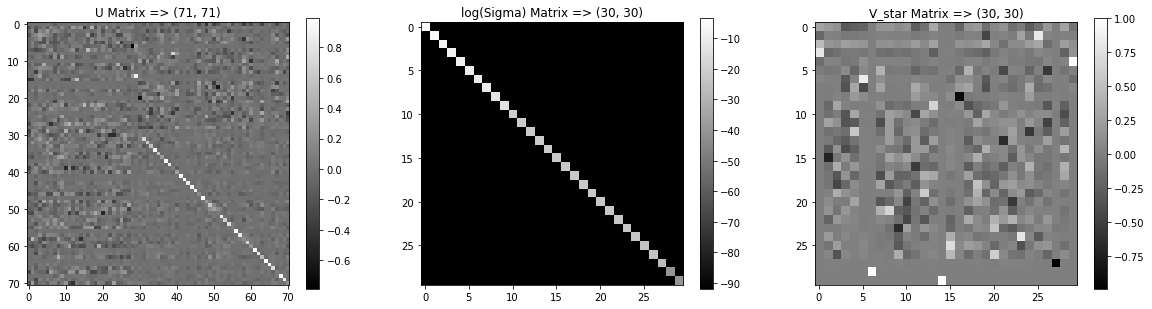

In [ ]:
visualize_SVD(W2)

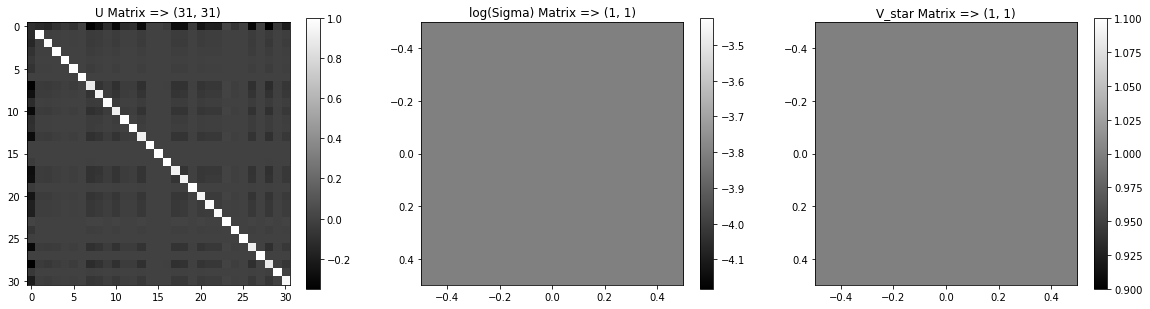

In [ ]:
visualize_SVD(W3)

### Estimating NN Params

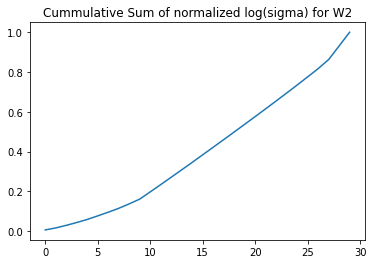

In [ ]:
_, sigma, _ = np.linalg.svd(W2)
log_sigma = np.log(sigma)
csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))

plt.plot(csum_norm_log_sigma)
plt.title("Cummulative Sum of normalized log(sigma) for W2")
plt.show()

In [ ]:
h1 = get_new_param(W1)
h1

13

In [ ]:
h2 = get_new_param(W2)
h2

12

### Fitting New Model

In [ ]:
n_model = get_model((34,), hidden=[h1, h2], n_class=2, task="class")
n_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 13)                455       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 636
Trainable params: 636
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_v2(n_model, train_ds, val_ds, 100, bce_loss)

Epoch 1/100
30/30 - 2s - loss: 0.6057 - accuracy: 0.7083 - prec: 0.6944 - rec: 0.9740 - auc: 0.6796 - val_loss: 0.5638 - val_accuracy: 0.7344 - val_prec: 0.7118 - val_rec: 0.9837 - val_auc: 0.7700
Epoch 2/100
30/30 - 0s - loss: 0.5551 - accuracy: 0.7500 - prec: 0.7243 - rec: 0.9936 - auc: 0.7667 - val_loss: 0.5087 - val_accuracy: 0.7708 - val_prec: 0.7486 - val_rec: 1.0000 - val_auc: 0.8100
Epoch 3/100
30/30 - 0s - loss: 0.5183 - accuracy: 0.7583 - prec: 0.7324 - rec: 0.9936 - auc: 0.8227 - val_loss: 0.4894 - val_accuracy: 0.7708 - val_prec: 0.7333 - val_rec: 1.0000 - val_auc: 0.8781
Epoch 4/100
30/30 - 0s - loss: 0.4885 - accuracy: 0.7792 - prec: 0.7488 - rec: 0.9936 - auc: 0.8649 - val_loss: 0.4485 - val_accuracy: 0.7865 - val_prec: 0.7574 - val_rec: 1.0000 - val_auc: 0.9122
Epoch 5/100
30/30 - 0s - loss: 0.4574 - accuracy: 0.8083 - prec: 0.7750 - rec: 0.9936 - auc: 0.8875 - val_loss: 0.4423 - val_accuracy: 0.8229 - val_prec: 0.7829 - val_rec: 0.9917 - val_auc: 0.9083
Epoch 6/100
30/

### Summary

In [ ]:
# Old Model

final_summary(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 70)                2450      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________
Train Score:
31/31 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.9959 - prec: 0.9937 - rec: 1.0000 - auc: 1.0000
Valid Score:
5/5 [==============================] - 0s 4ms/step - loss: 0.3478 - accuracy: 0.8857 - prec: 0.8800 - rec: 0.9565 - auc: 0.9710
Test Score:
9/9 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9437 -

In [ ]:
# New Model 
final_summary(n_model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 13)                455       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 636
Trainable params: 636
Non-trainable params: 0
_________________________________________________________________
Train Score:
31/31 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9878 - prec: 0.9875 - rec: 0.9937 - auc: 0.9971
Valid Score:
5/5 [==============================] - 0s 4ms/step - loss: 0.3984 - accuracy: 0.8571 - prec: 0.8462 - rec: 0.9565 - auc: 0.9366
Test Score:
9/9 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.9296 - pre

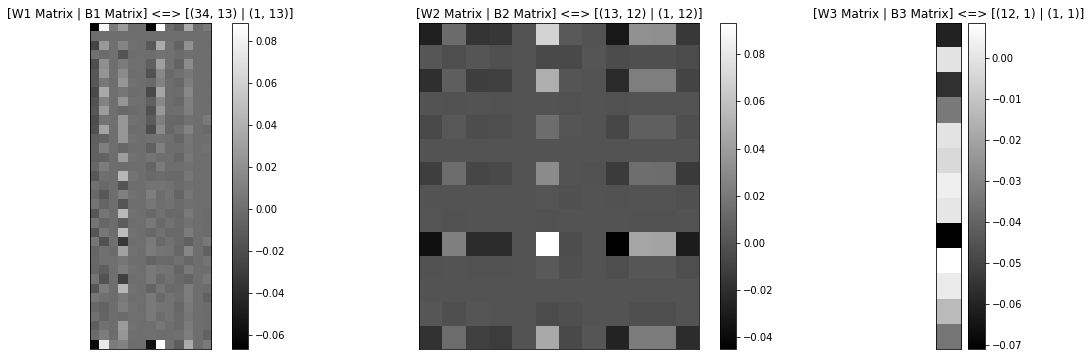

In [ ]:
[W1, W2, W3] = plot_jacobian(n_model, bce_loss)

# Ablone Data 
+ 3-Class Classification
+ 4177 records (1528 + 1307 + 1342)

### Data Preparation

In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

--2021-07-01 11:28:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: ‘abalone.data’

abalone.data        100%[===================>] 187.38K  --.-KB/s    in 0.1s    

2021-07-01 11:28:36 (1.63 MB/s) - ‘abalone.data’ saved [191873/191873]



In [ ]:
data = pd.read_csv("abalone.data", header=None)
class_dict = {"M": 0, "F": 1, "I": 2}
X = data[np.arange(1, 9)].values
Y = data[0].apply(lambda x: class_dict[x]).values
Y = np.eye(3)[Y]

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)

### Modelling

In [ ]:
model = get_model((8,), hidden = [100, 50], n_class=3, task="class")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               900       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 153       
Total params: 6,103
Trainable params: 6,103
Non-trainable params: 0
_________________________________________________________________


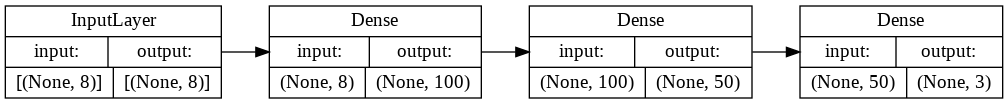

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
history = train_v2(model, train_ds, val_ds, 100, smx_loss)

Epoch 1/100
365/365 - 3s - loss: 1.1023 - accuracy: 0.4466 - prec: 0.4657 - rec: 0.2514 - auc: 0.6327 - val_loss: 0.9335 - val_accuracy: 0.5281 - val_prec: 0.5697 - val_rec: 0.3944 - val_auc: 0.7344
Epoch 2/100
365/365 - 1s - loss: 0.9586 - accuracy: 0.5257 - prec: 0.5814 - rec: 0.4038 - auc: 0.7244 - val_loss: 0.9702 - val_accuracy: 0.5153 - val_prec: 0.5582 - val_rec: 0.4462 - val_auc: 0.7239
Epoch 3/100
365/365 - 1s - loss: 0.9519 - accuracy: 0.5277 - prec: 0.5727 - rec: 0.4277 - auc: 0.7324 - val_loss: 0.9293 - val_accuracy: 0.5378 - val_prec: 0.5677 - val_rec: 0.4729 - val_auc: 0.7475
Epoch 4/100
365/365 - 1s - loss: 0.9571 - accuracy: 0.5233 - prec: 0.5583 - rec: 0.4329 - auc: 0.7323 - val_loss: 1.0379 - val_accuracy: 0.5115 - val_prec: 0.5284 - val_rec: 0.4615 - val_auc: 0.6975
Epoch 5/100
365/365 - 1s - loss: 0.9208 - accuracy: 0.5267 - prec: 0.5645 - rec: 0.3959 - auc: 0.7444 - val_loss: 0.8733 - val_accuracy: 0.5417 - val_prec: 0.5837 - val_rec: 0.4514 - val_auc: 0.7688
Epoch

### Results

In [ ]:
# Train Scores
print("Train Score:")
model.evaluate(train_ds.batch(8))

# Validation Scores
print("Valid Score:")
model.evaluate(val_ds.batch(8))

# Testing Scores
print("Test Score:")
model.evaluate(test_ds.batch(8));

Train Score:
366/366 [==============================] - 2s 4ms/step - loss: 0.8636 - accuracy: 0.5412 - prec: 0.6352 - rec: 0.3544 - auc: 0.7739
Valid Score:
53/53 [==============================] - 0s 4ms/step - loss: 0.8951 - accuracy: 0.5167 - prec: 0.5837 - rec: 0.3254 - auc: 0.7504
Test Score:
105/105 [==============================] - 0s 4ms/step - loss: 0.8201 - accuracy: 0.5538 - prec: 0.6509 - rec: 0.3612 - auc: 0.7912


### Jacobian Visualization

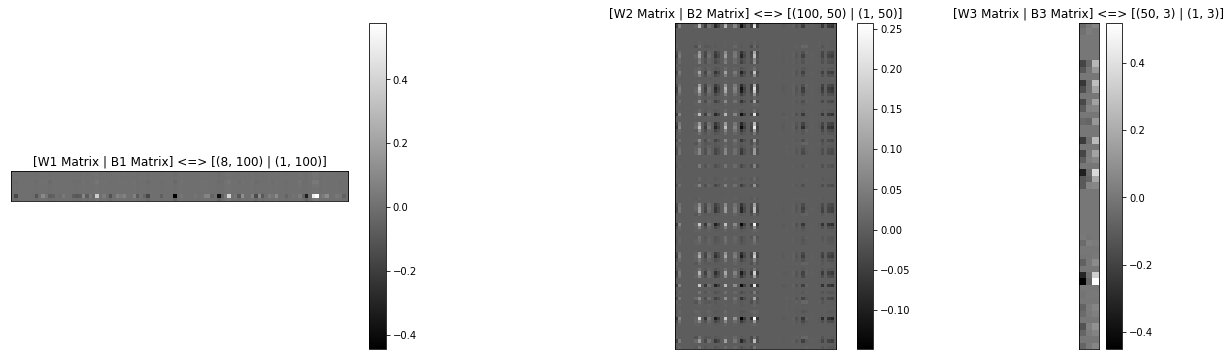

In [ ]:
[W1, W2, W3] = plot_jacobian(model, smx_loss)

### SVD of Jacobians

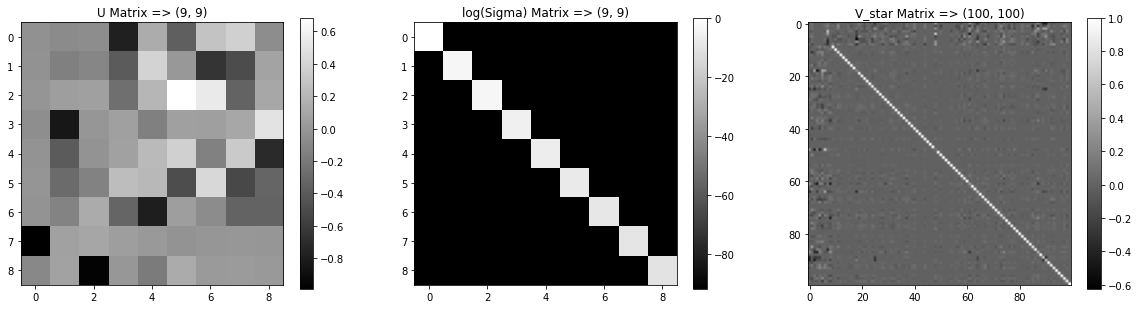

In [ ]:
visualize_SVD(W1)

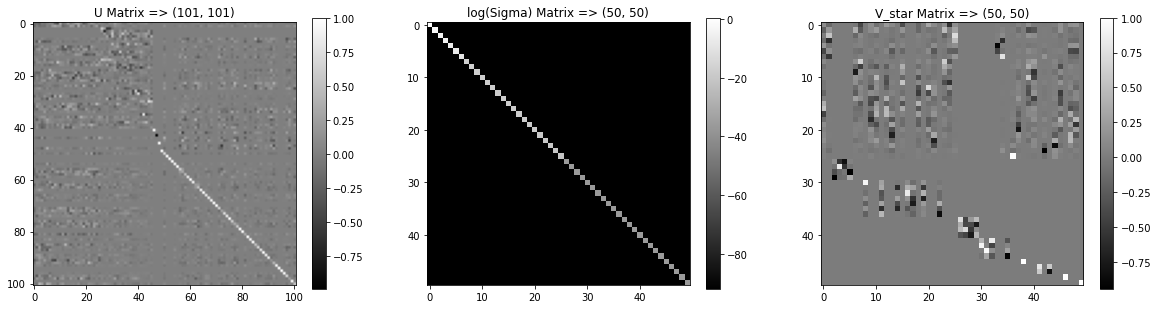

In [ ]:
visualize_SVD(W2)

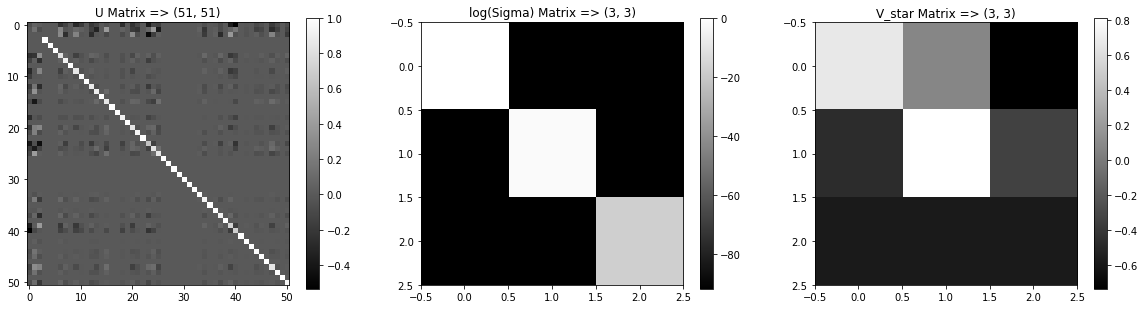

In [ ]:
visualize_SVD(W3)

### Estimating NN Params

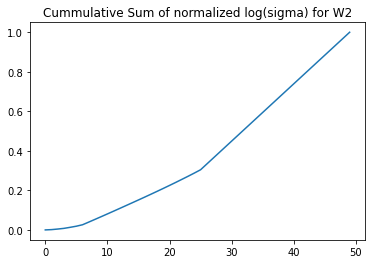

In [ ]:
_, sigma, _ = np.linalg.svd(W2)
log_sigma = np.log(sigma)
csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))

plt.plot(csum_norm_log_sigma)
plt.title("Cummulative Sum of normalized log(sigma) for W2")
plt.show()

In [ ]:
h1 = get_new_param(W1)
h1

4

In [ ]:
h2 = get_new_param(W2)
h2

20

### Fitting New Model

In [ ]:
n_model = get_model((8,), hidden=[h1, h2], n_class=3, task="class")
n_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_16 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 63        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_v2(n_model, train_ds, val_ds, 100, smx_loss)

Epoch 1/100
365/365 - 3s - loss: 1.4227 - accuracy: 0.4312 - prec: 0.4129 - rec: 0.1250 - auc: 0.6228 - val_loss: 1.0357 - val_accuracy: 0.4069 - val_prec: 0.4568 - val_rec: 0.1524 - val_auc: 0.6262
Epoch 2/100
365/365 - 1s - loss: 0.9766 - accuracy: 0.4863 - prec: 0.5646 - rec: 0.1692 - auc: 0.7035 - val_loss: 0.9636 - val_accuracy: 0.4903 - val_prec: 0.5288 - val_rec: 0.2451 - val_auc: 0.7045
Epoch 3/100
365/365 - 1s - loss: 0.9340 - accuracy: 0.5086 - prec: 0.6090 - rec: 0.2363 - auc: 0.7360 - val_loss: 0.9131 - val_accuracy: 0.5073 - val_prec: 0.6621 - val_rec: 0.2347 - val_auc: 0.7509
Epoch 4/100
365/365 - 1s - loss: 0.9221 - accuracy: 0.5195 - prec: 0.5961 - rec: 0.3007 - auc: 0.7393 - val_loss: 0.9092 - val_accuracy: 0.5306 - val_prec: 0.5803 - val_rec: 0.4066 - val_auc: 0.7473
Epoch 5/100
365/365 - 1s - loss: 0.9062 - accuracy: 0.5188 - prec: 0.6077 - rec: 0.3315 - auc: 0.7497 - val_loss: 0.8978 - val_accuracy: 0.5170 - val_prec: 0.6482 - val_rec: 0.2719 - val_auc: 0.7543
Epoch

### Summary

In [ ]:
# Old Model

final_summary(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               900       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 153       
Total params: 6,103
Trainable params: 6,103
Non-trainable params: 0
_________________________________________________________________
Train Score:
366/366 [==============================] - 2s 6ms/step - loss: 0.8636 - accuracy: 0.5412 - prec: 0.6352 - rec: 0.3544 - auc: 0.7739
Valid Score:
53/53 [==============================] - 0s 4ms/step - loss: 0.8951 - accuracy: 0.5167 - prec: 0.5837 - rec: 0.3254 - auc: 0.7504
Test Score:
105/105 [==============================] - 0s 4ms/step - loss: 0.8201 - accuracy: 

In [ ]:
# New Model 
final_summary(n_model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_16 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 63        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Train Score:
366/366 [==============================] - 2s 4ms/step - loss: 0.8841 - accuracy: 0.5412 - prec: 0.6226 - rec: 0.3510 - auc: 0.7618
Valid Score:
53/53 [==============================] - 0s 4ms/step - loss: 0.9188 - accuracy: 0.4904 - prec: 0.5447 - rec: 0.3349 - auc: 0.7347
Test Score:
105/105 [==============================] - 0s 4ms/step - loss: 0.8382 - accuracy: 0.55

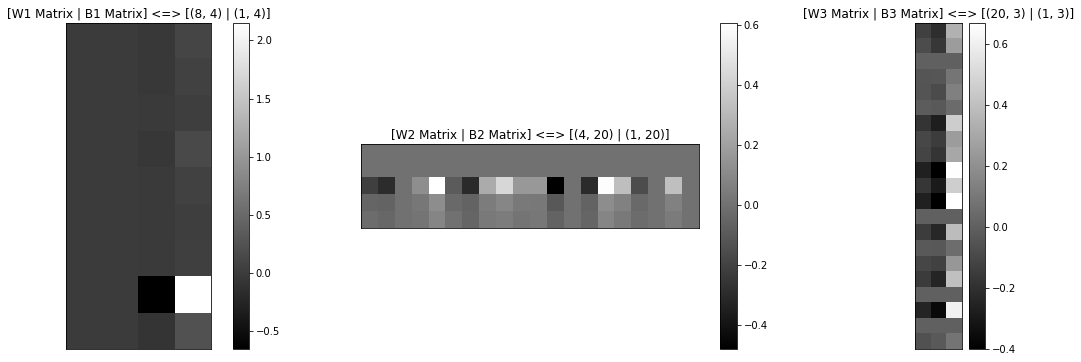

In [ ]:
[W1, W2, W3] = plot_jacobian(n_model, smx_loss)

# Spine Data
+ 3 class classification
+ 310 records (150 + 100 + 60)

### Data Preparation

In [ ]:
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip
! unzip vertebral_column_data.zip -d vertebral_column_data

--2021-07-01 11:29:42--  http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33251 (32K) [application/x-httpd-php]
Saving to: ‘vertebral_column_data.zip’

vertebral_column_da 100%[===================>]  32.47K  --.-KB/s    in 0.04s   

2021-07-01 11:29:42 (903 KB/s) - ‘vertebral_column_data.zip’ saved [33251/33251]

Archive:  vertebral_column_data.zip
  inflating: vertebral_column_data/column_2C.dat  
  inflating: vertebral_column_data/column_2C_weka.arff  
  inflating: vertebral_column_data/column_3C.dat  
  inflating: vertebral_column_data/column_3C_weka.arff  


In [ ]:
class_dict = {'DH': 0, 'SL': 1, 'NO': 2}

In [ ]:
data = pd.read_csv("vertebral_column_data/column_3C.dat", header=None, sep=" ")
X = data[np.arange(5)].values
Y = data[6].apply(lambda x: class_dict[x]).values
Y = np.eye(3)[Y]

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)

### Modelling

In [ ]:
model = get_model((5,), hidden = [70, 30], n_class=3, task="class")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 70)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 93        
Total params: 2,643
Trainable params: 2,643
Non-trainable params: 0
_________________________________________________________________


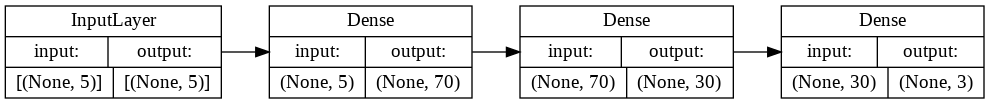

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
history = train_v2(model, train_ds, val_ds, 100, smx_loss)

Epoch 1/100
27/27 - 2s - loss: 16.0158 - accuracy: 0.5231 - prec: 0.5231 - rec: 0.5231 - auc: 0.6486 - val_loss: 8.0009 - val_accuracy: 0.4375 - val_prec: 0.4375 - val_rec: 0.4375 - val_auc: 0.6031
Epoch 2/100
27/27 - 0s - loss: 3.3055 - accuracy: 0.5648 - prec: 0.5728 - rec: 0.5648 - auc: 0.7199 - val_loss: 1.9031 - val_accuracy: 0.6510 - val_prec: 0.6492 - val_rec: 0.6458 - val_auc: 0.7877
Epoch 3/100
27/27 - 0s - loss: 1.7857 - accuracy: 0.6343 - prec: 0.6343 - rec: 0.6343 - auc: 0.7854 - val_loss: 1.7077 - val_accuracy: 0.5677 - val_prec: 0.5753 - val_rec: 0.5573 - val_auc: 0.7796
Epoch 4/100
27/27 - 0s - loss: 1.6031 - accuracy: 0.5787 - prec: 0.5814 - rec: 0.5787 - auc: 0.7731 - val_loss: 1.3584 - val_accuracy: 0.6458 - val_prec: 0.6575 - val_rec: 0.6198 - val_auc: 0.8153
Epoch 5/100
27/27 - 0s - loss: 1.1177 - accuracy: 0.6481 - prec: 0.6493 - rec: 0.6343 - auc: 0.8257 - val_loss: 0.7994 - val_accuracy: 0.6823 - val_prec: 0.6957 - val_rec: 0.6667 - val_auc: 0.8642
Epoch 6/100
27

### Results

In [ ]:
# Train Scores
print("Train Score:")
model.evaluate(train_ds.batch(8))

# Validation Scores
print("Valid Score:")
model.evaluate(val_ds.batch(8))

# Testing Scores
print("Test Score:")
model.evaluate(test_ds.batch(8));

Train Score:
28/28 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.7419 - prec: 0.7561 - rec: 0.7143 - auc: 0.9102
Valid Score:
4/4 [==============================] - 0s 4ms/step - loss: 1.3162 - accuracy: 0.5484 - prec: 0.5484 - rec: 0.5484 - auc: 0.7562
Test Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.8626 - accuracy: 0.6613 - prec: 0.6949 - rec: 0.6613 - auc: 0.8682


### Jacobian Visualization

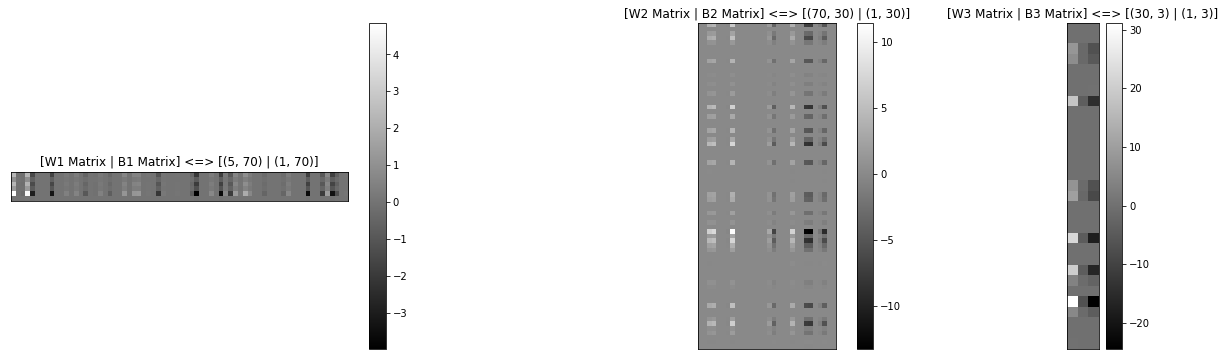

In [ ]:
[W1, W2, W3] = plot_jacobian(model, smx_loss)

### SVD of Jacobians

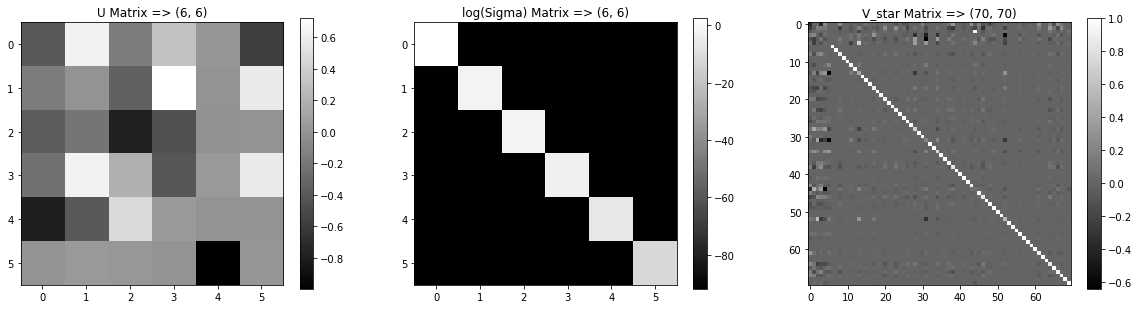

In [ ]:
visualize_SVD(W1)

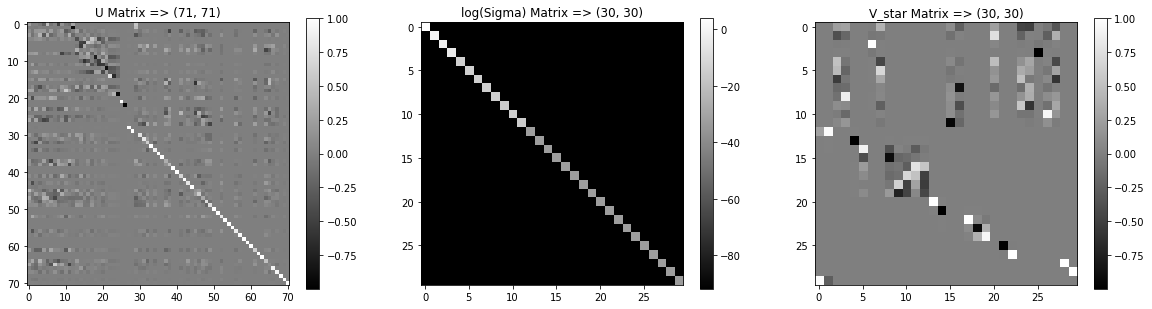

In [ ]:
visualize_SVD(W2)

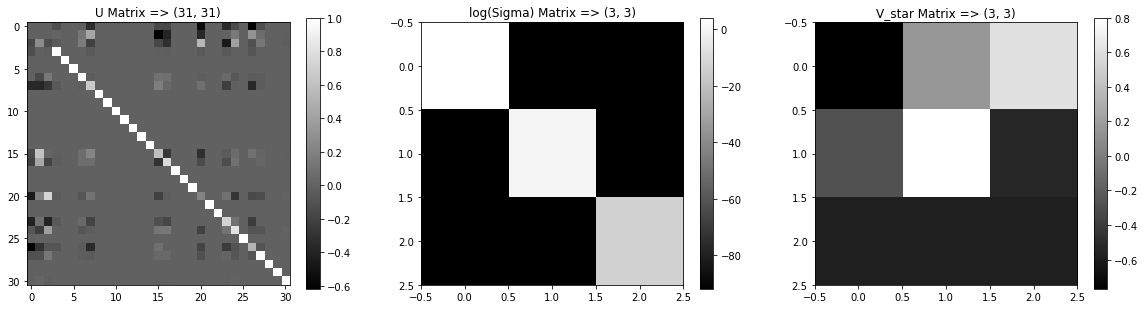

In [ ]:
visualize_SVD(W3)

### Estimating NN Params

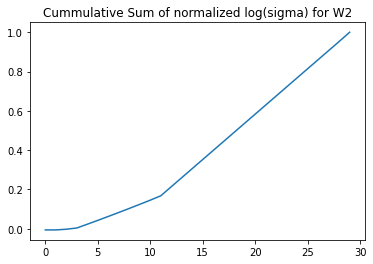

In [ ]:
_, sigma, _ = np.linalg.svd(W2)
log_sigma = np.log(sigma)
csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))

plt.plot(csum_norm_log_sigma)
plt.title("Cummulative Sum of normalized log(sigma) for W2")
plt.show()

In [ ]:
h1 = get_new_param(W1)
h1

5

In [ ]:
h2 = get_new_param(W2)
h2

13

### Fitting New Model

In [ ]:
n_model = get_model((5,), hidden=[h1, h2], n_class=3, task="class")
n_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_22 (Dense)             (None, 13)                78        
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 42        
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_v2(n_model, train_ds, val_ds, 100, smx_loss)

Epoch 1/100
27/27 - 2s - loss: 75.8683 - accuracy: 0.1991 - prec: 0.1991 - rec: 0.1991 - auc: 0.3944 - val_loss: 46.1914 - val_accuracy: 0.1979 - val_prec: 0.1979 - val_rec: 0.1979 - val_auc: 0.3944
Epoch 2/100
27/27 - 0s - loss: 28.8308 - accuracy: 0.2407 - prec: 0.2407 - rec: 0.2407 - auc: 0.4099 - val_loss: 10.7178 - val_accuracy: 0.2344 - val_prec: 0.2368 - val_rec: 0.2344 - val_auc: 0.4365
Epoch 3/100
27/27 - 0s - loss: 11.0737 - accuracy: 0.3750 - prec: 0.3750 - rec: 0.3750 - auc: 0.5393 - val_loss: 9.6532 - val_accuracy: 0.4479 - val_prec: 0.4479 - val_rec: 0.4479 - val_auc: 0.5731
Epoch 4/100
27/27 - 0s - loss: 9.8551 - accuracy: 0.4167 - prec: 0.4159 - rec: 0.4120 - auc: 0.5663 - val_loss: 8.9173 - val_accuracy: 0.4688 - val_prec: 0.4688 - val_rec: 0.4688 - val_auc: 0.5940
Epoch 5/100
27/27 - 0s - loss: 9.1381 - accuracy: 0.4398 - prec: 0.4398 - rec: 0.4398 - auc: 0.5652 - val_loss: 8.7125 - val_accuracy: 0.4583 - val_prec: 0.4583 - val_rec: 0.4583 - val_auc: 0.5903
Epoch 6/10

### Summary

In [ ]:
# Old Model

final_summary(model)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 70)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 93        
Total params: 2,643
Trainable params: 2,643
Non-trainable params: 0
_________________________________________________________________
Train Score:
28/28 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.7419 - prec: 0.7561 - rec: 0.7143 - auc: 0.9102
Valid Score:
4/4 [==============================] - 0s 4ms/step - loss: 1.3162 - accuracy: 0.5484 - prec: 0.5484 - rec: 0.5484 - auc: 0.7562
Test Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.8626 - accuracy: 0.6613 -

In [ ]:
# New Model 
final_summary(n_model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_22 (Dense)             (None, 13)                78        
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 42        
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________
Train Score:
28/28 [==============================] - 0s 4ms/step - loss: 0.7999 - accuracy: 0.6728 - prec: 0.7692 - rec: 0.4608 - auc: 0.8340
Valid Score:
4/4 [==============================] - 0s 4ms/step - loss: 0.9201 - accuracy: 0.4516 - prec: 0.5833 - rec: 0.4516 - auc: 0.7263
Test Score:
8/8 [==============================] - 0s 4ms/step - loss: 0.9635 - accuracy: 0.5000 - pre

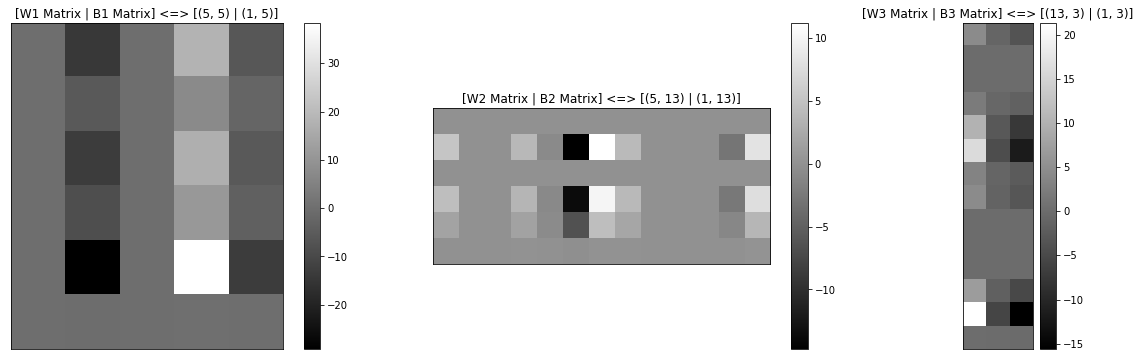

In [ ]:
[W1, W2, W3] = plot_jacobian(n_model, smx_loss)

# Forest Data
+ Regression
+ 517 records

### Data Preparation

In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv

--2021-07-01 11:30:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25478 (25K) [application/x-httpd-php]
Saving to: ‘forestfires.csv’

forestfires.csv     100%[===================>]  24.88K  --.-KB/s    in 0.03s   

2021-07-01 11:30:01 (879 KB/s) - ‘forestfires.csv’ saved [25478/25478]



In [ ]:
mon_dict= {'jan': 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
           "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}

day_dict = {"sun":1, "mon": 2, "tue":3, "wed": 4, "thu": 5, "fri": 6, "sat": 7}

In [ ]:
data = pd.read_csv("forestfires.csv")
data["month"] = data["month"].apply(lambda x: mon_dict[x])
data["day"] = data["day"].apply(lambda x: day_dict[x])
X = data[['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain']].values
Y = data["area"].values

In [ ]:
train_ds, val_ds, test_ds = get_dataset(X, Y)

### Modelling

In [ ]:
model = get_model((12,), hidden = [70, 30], task="reg")
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 70)                910       
_________________________________________________________________
dense_25 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 31        
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________


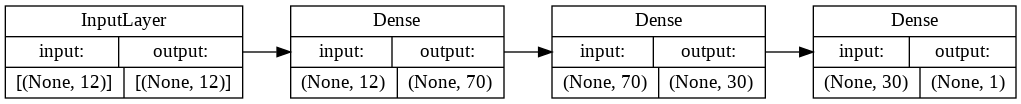

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
history = train_v2(model, train_ds, val_ds, 100, reg_loss, patience=20, task="reg")

Epoch 1/100
45/45 - 1s - loss: 3098.6121 - mae: 33.0666 - msle: 5.1380 - rmse: 55.6652 - val_loss: 1100.2429 - val_mae: 20.8140 - val_msle: 4.8334 - val_rmse: 33.1699
Epoch 2/100
45/45 - 0s - loss: 2381.8442 - mae: 20.1602 - msle: 4.3766 - rmse: 48.8041 - val_loss: 2305.8435 - val_mae: 18.6726 - val_msle: 4.3725 - val_rmse: 48.0192
Epoch 3/100
45/45 - 0s - loss: 2331.4221 - mae: 16.9273 - msle: 3.7889 - rmse: 48.2848 - val_loss: 2416.2007 - val_mae: 25.9938 - val_msle: 6.3292 - val_rmse: 49.1549
Epoch 4/100
45/45 - 0s - loss: 2361.3481 - mae: 19.1777 - msle: 4.1591 - rmse: 48.5937 - val_loss: 2766.8179 - val_mae: 28.9977 - val_msle: 6.3902 - val_rmse: 52.6006
Epoch 5/100
45/45 - 0s - loss: 2362.4907 - mae: 18.8114 - msle: 3.9064 - rmse: 48.6055 - val_loss: 3162.0574 - val_mae: 36.2539 - val_msle: 7.8854 - val_rmse: 56.2322
Epoch 6/100
45/45 - 0s - loss: 2421.3652 - mae: 19.5384 - msle: 4.2983 - rmse: 49.2074 - val_loss: 2572.8779 - val_mae: 26.3657 - val_msle: 6.1908 - val_rmse: 50.723

### Results

In [ ]:
# Train Scores
print("Train Score:")
model.evaluate(train_ds.batch(8))

# Validation Scores
print("Valid Score:")
model.evaluate(val_ds.batch(8))

# Testing Scores
print("Test Score:")
model.evaluate(test_ds.batch(8));

Train Score:
46/46 [==============================] - 0s 3ms/step - loss: 2240.3508 - mae: 14.6112 - msle: 3.0092 - rmse: 47.3323
Valid Score:
7/7 [==============================] - 0s 3ms/step - loss: 534.0731 - mae: 10.1485 - msle: 3.0993 - rmse: 23.1100
Test Score:
13/13 [==============================] - 0s 2ms/step - loss: 11919.6094 - mae: 22.5075 - msle: 3.1076 - rmse: 109.1770


### Jacobian Visualization

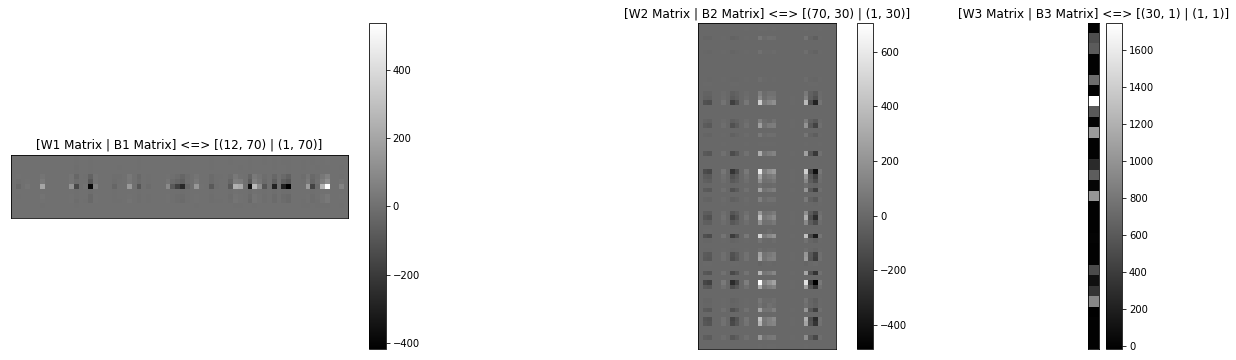

In [ ]:
[W1, W2, W3] = plot_jacobian(model, reg_loss)

### SVD of Jacobians

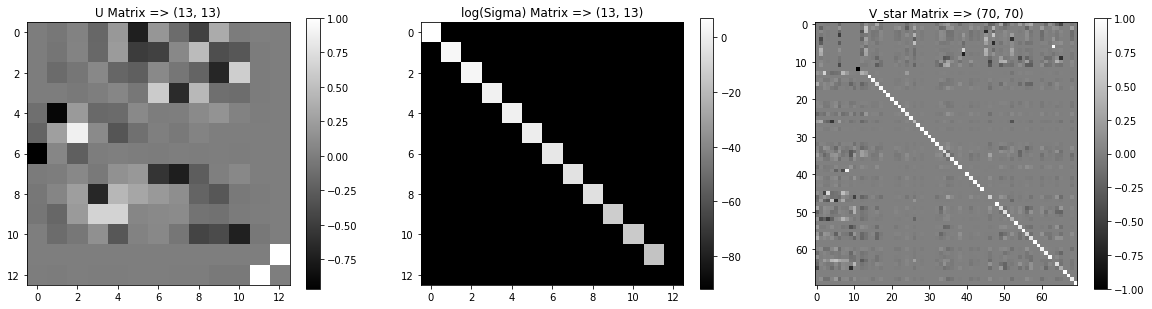

In [ ]:
visualize_SVD(W1)

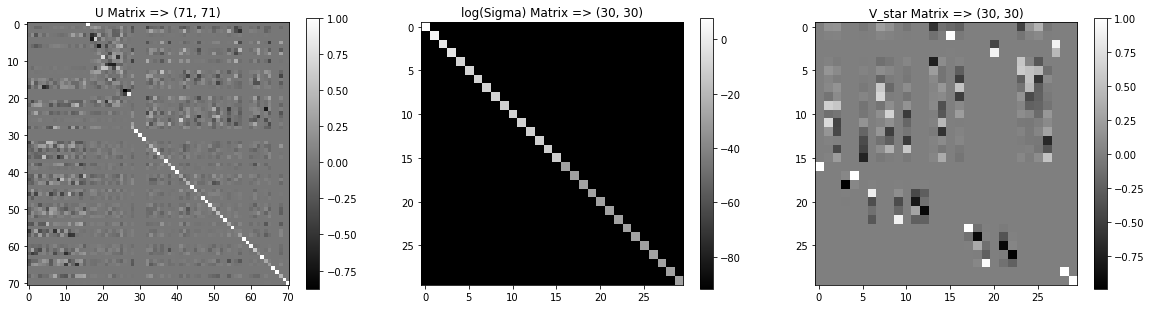

In [ ]:
visualize_SVD(W2)

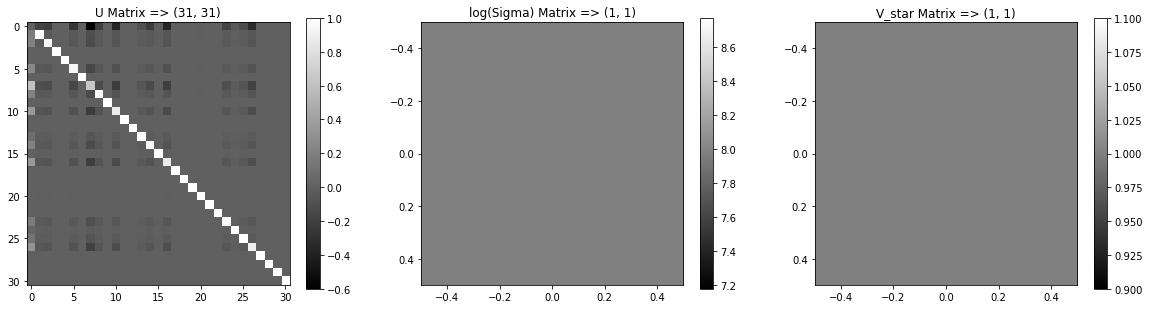

In [ ]:
visualize_SVD(W3)

### Estimating NN Params

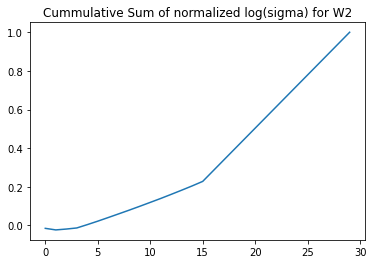

In [ ]:
_, sigma, _ = np.linalg.svd(W2)
log_sigma = np.log(sigma)
csum_norm_log_sigma = np.cumsum(log_sigma/np.sum(log_sigma))

plt.plot(csum_norm_log_sigma)
plt.title("Cummulative Sum of normalized log(sigma) for W2")
plt.show()

In [ ]:
h1 = get_new_param(W1)
h1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


13

In [ ]:
h2 = get_new_param(W2)
h2

15

### Fitting New Model

In [ ]:
n_model = get_model((12,), hidden=[h1, h2], task="reg")
n_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 13)                169       
_________________________________________________________________
dense_28 (Dense)             (None, 15)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 16        
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_v2(n_model, train_ds, val_ds, 100, reg_loss, patience=20, task="reg")

Epoch 1/100
45/45 - 1s - loss: 3398.9902 - mae: 38.4077 - msle: 8.0970 - rmse: 58.3009 - val_loss: 2531.6392 - val_mae: 26.4044 - val_msle: 6.4699 - val_rmse: 50.3154
Epoch 2/100
45/45 - 0s - loss: 2399.0930 - mae: 22.2131 - msle: 5.3782 - rmse: 48.9805 - val_loss: 2382.4609 - val_mae: 20.1532 - val_msle: 4.9224 - val_rmse: 48.8105
Epoch 3/100
45/45 - 0s - loss: 2325.9998 - mae: 19.3952 - msle: 4.6617 - rmse: 48.2286 - val_loss: 2544.1677 - val_mae: 18.3816 - val_msle: 4.3135 - val_rmse: 50.4397
Epoch 4/100
45/45 - 0s - loss: 2314.2222 - mae: 17.9718 - msle: 4.2611 - rmse: 48.1064 - val_loss: 2558.6138 - val_mae: 17.6446 - val_msle: 3.9153 - val_rmse: 50.5827
Epoch 5/100
45/45 - 0s - loss: 2307.7046 - mae: 16.5402 - msle: 3.7925 - rmse: 48.0386 - val_loss: 2544.7229 - val_mae: 16.9464 - val_msle: 3.7239 - val_rmse: 50.4452
Epoch 6/100
45/45 - 0s - loss: 2293.5388 - mae: 16.4247 - msle: 3.7301 - rmse: 47.8909 - val_loss: 2542.1804 - val_mae: 17.0096 - val_msle: 3.7141 - val_rmse: 50.420

### Summary

In [ ]:
# Old Model

final_summary(model)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 70)                910       
_________________________________________________________________
dense_25 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 31        
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________
Train Score:
46/46 [==============================] - 0s 2ms/step - loss: 2240.3508 - mae: 14.6112 - msle: 3.0092 - rmse: 47.3323
Valid Score:
7/7 [==============================] - 0s 3ms/step - loss: 534.0731 - mae: 10.1485 - msle: 3.0993 - rmse: 23.1100
Test Score:
13/13 [==============================] - 0s 2ms/step - loss: 11919.6094 - mae: 22.5075 - msle: 3.1076 - rmse: 109

In [ ]:
# New Model 
final_summary(n_model)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 13)                169       
_________________________________________________________________
dense_28 (Dense)             (None, 15)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 16        
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________
Train Score:
46/46 [==============================] - 0s 2ms/step - loss: 2253.5615 - mae: 15.5753 - msle: 3.3680 - rmse: 47.4717
Valid Score:
7/7 [==============================] - 0s 3ms/step - loss: 548.2040 - mae: 11.1620 - msle: 3.3872 - rmse: 23.4138
Test Score:
13/13 [==============================] - 0s 3ms/step - loss: 11979.5605 - mae: 23.8537 - msle: 3.6069 - rmse: 109.451

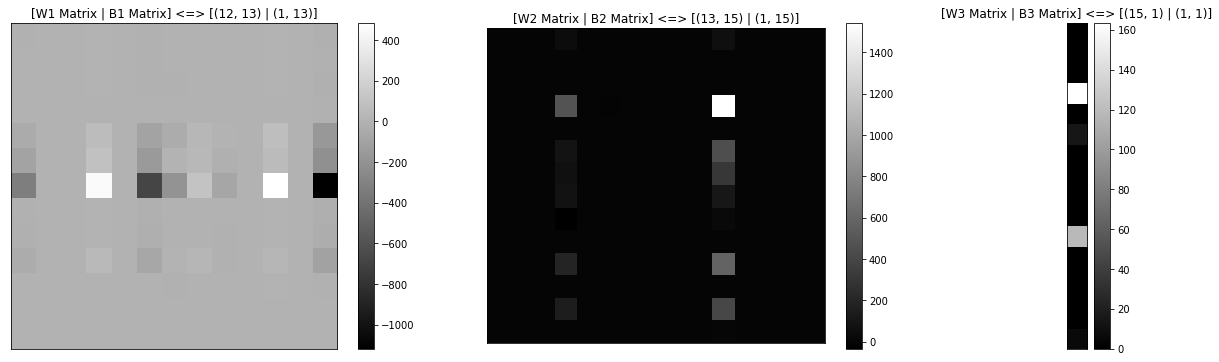

In [ ]:
[W1, W2, W3] = plot_jacobian(n_model, reg_loss)

# Tensorboard

In [ ]:
# Only Run Once. If train function is evalated more than one time, hit refresh button next to inactive.

#%tensorboard --logdir "logs"
print()

# Better Explanations

+ Naitzat, G., Zhitnikov, A., & Lim, L. H. (2020). **Topology of Deep Neural Networks**. Journal of Machine Learning Research, 21(184), 1-40. [[link]](https://arxiv.org/abs/2004.06093)
+ Hauser, Michael B & Ray, Asok **Principles of Riemannian geometry in neural networks**, (2018). [[link]](https://papers.nips.cc/paper/2017/hash/0ebcc77dc72360d0eb8e9504c78d38bd-Abstract.html)
+ Arvanitidis, G., Hansen, L.K. and Hauberg, S., 2017. **Latent space oddity: on the curvature of deep generative models**. arXiv preprint arXiv:1710.11379. [[link]](https://arxiv.org/abs/1710.11379)
+ C.  Olah.   **Neural  Networks,  Manifolds,  and  Topology**, 2014. [[link]](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/)

# Possible Other Directions

+ [AutoML Project](https://www.automl.org/automl/)